# Lab 07: Time Series Feature Extraction and Clustering

This notebook provides an introduction to extracting features from time series data
and applying clustering algorithms. We will explore different feature extraction
techniques and compare the results of standard k-means clustering with bisecting k-means.

## Section 1: Time Series Feature Extraction

In this section, we will explore different methods for extracting meaningful features
from time series data. These features can then be used as input for various
machine learning tasks, such as clustering, classification, or regression. We will
focus on Electrocardiogram (EKG) or EKG-like time series data.

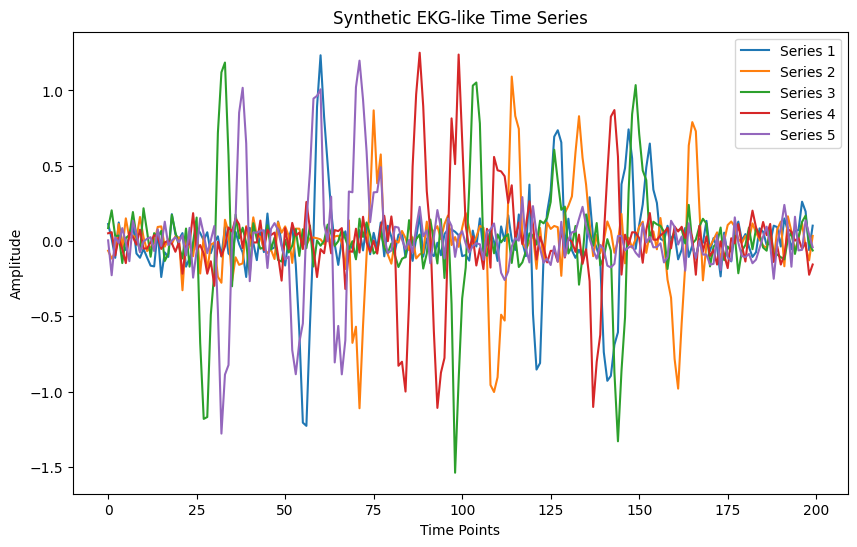

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

# set random seed for reproducibility
random_state = 67
np.random.seed(random_state)

# Generate synthetic EKG-like data
n_series = 150
length = 200
ekg_data = []
for _ in range(n_series):
    base_line = np.random.randn(length) * 0.1
    qrs_complex = np.zeros(length)
    peak_indices = np.sort(np.random.choice(np.arange(20, length - 20), size=3, replace=False))
    for peak in peak_indices:
        qrs_complex[peak-5:peak+6] += np.sin(np.linspace(-np.pi, np.pi, 11)) + np.random.randn(11) * 0.2
    t_wave = np.zeros(length)
    t_peak = peak_indices[1] + np.random.randint(10, 30)
    if 0 <= t_peak < length:
        t_wave[t_peak-3:t_peak+4] += 0.5 * np.exp(-np.linspace(-1, 1, 7)**2) + np.random.randn(7) * 0.1
    ekg_series = base_line + qrs_complex + t_wave
    ekg_data.append(ekg_series)

ekg_df = pd.DataFrame(ekg_data).T
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(ekg_df[i], label=f'Series {i+1}')
plt.title('Synthetic EKG-like Time Series')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Example 1: Statistical and Peak-Based Features

In this example, we will extract a set of descriptive statistical features along with
the number of prominent peaks present in each time series.

**Task:** For each of the generated EKG-like time series, calculate the following features:

* Mean
* Standard Deviation
* Skewness
* Kurtosis
* Number of Peaks (you can use `scipy.signal.find_peaks`)

Store these features in a Pandas DataFrame where each row represents a time series
and each column represents a feature.

In [2]:
# Feature Extraction - Example 1
features_ex1 = []
for i in range(n_series):
    series = ekg_df[i].values
    mean_val = np.mean(series)
    std_val = np.std(series)
    skew_val = skew(series)
    kurt_val = kurtosis(series)
    peaks, _ = find_peaks(series, prominence=0.5) # Adjust prominence as needed
    n_peaks = len(peaks)
    features_ex1.append([mean_val, std_val, skew_val, kurt_val, n_peaks])

features_df_ex1 = pd.DataFrame(features_ex1, columns=['mean', 'std', 'skewness', 'kurtosis', 'n_peaks'])
print("Features (Example 1):\n", features_df_ex1)

Features (Example 1):
          mean       std  skewness  kurtosis  n_peaks
0    0.000176  0.292057 -0.430560  5.689415        5
1    0.002328  0.286658 -0.295270  4.789525        4
2    0.005266  0.333830 -0.460550  6.551689        4
3    0.009330  0.310083  0.169164  5.155564        5
4    0.004379  0.310405  0.323320  5.077231        4
..        ...       ...       ...       ...      ...
145 -0.003038  0.310399 -0.716550  6.216885        4
146  0.006544  0.301172 -0.414093  6.294980        4
147  0.006972  0.314723  0.097725  6.441009        4
148  0.017178  0.322320  0.505769  7.655419        3
149  0.013741  0.251342 -0.047823  7.558861        5

[150 rows x 5 columns]


### Example 2: Equal Width Partitioning with Mean and Standard Deviation

This method involves dividing each time series into a fixed number of equal-width
buckets and then calculating statistical measures within each bucket. This ensures
that all time series are represented by the same number of features, regardless
of their length or the distribution of their values.

**Task:**

1.  Define a function that takes a time series and the number of buckets (`n_buckets`) as input.
2.  Inside the function, divide the time series into `n_buckets` of equal width.
3.  For each bucket, calculate the mean and the standard deviation of the values within that bucket.
4.  The function should return a flattened array of these mean and standard deviation values. For example, if `n_buckets` is 5, the output should be an array of 10 features (mean\_bucket1, std\_bucket1, mean\_bucket2, std\_bucket2, ..., mean\_bucket5, std\_bucket5).
5.  Apply this function to each of the generated EKG-like time series using, say, `n_buckets = 5`.
6.  Store the resulting features in a Pandas DataFrame.

In [3]:
# Feature Extraction - Example 2
def equal_width_partitioning(series, n_buckets):
    min_val = np.min(series)
    max_val = np.max(series)
    bucket_width = (max_val - min_val) / n_buckets
    features = []
    for i in range(n_buckets):
        start = min_val + i * bucket_width
        end = min_val + (i + 1) * bucket_width
        bucket_values = series[(series >= start) & (series < end)]
        if len(bucket_values) > 0:
            features.append(np.mean(bucket_values))
            features.append(np.std(bucket_values))
        else:
            features.append(0) # Handle empty buckets
            features.append(0)
    return np.array(features)

n_buckets = 5
features_ex2 = []
for i in range(n_series):
    series = ekg_df[i].values
    features_ex2.append(equal_width_partitioning(series, n_buckets))

features_df_ex2 = pd.DataFrame(features_ex2, columns=[f'mean_bucket_{i//2 + 1}' if i % 2 == 0 else f'std_bucket_{(i-1)//2 + 1}' for i in range(n_buckets * 2)])
print("\nFeatures (Example 2):\n", features_df_ex2)


Features (Example 2):
      mean_bucket_1  std_bucket_1  mean_bucket_2  std_bucket_2  mean_bucket_3  \
0        -0.950991      0.177168      -0.588037      0.066811      -0.006208   
1        -0.915843      0.134385      -0.378641      0.131958       0.009301   
2        -1.304249      0.149193      -0.721539      0.175679      -0.043877   
3        -0.911311      0.129061      -0.290767      0.132968       0.010380   
4        -0.927288      0.160278      -0.604508      0.089167      -0.017365   
..             ...           ...            ...           ...            ...   
145      -1.284493      0.233608      -0.811342      0.149060      -0.069007   
146      -1.073788      0.109277      -0.341647      0.123506       0.013322   
147      -0.881067      0.190438      -0.152931      0.101479       0.060121   
148      -0.942877      0.180207      -0.219926      0.112470       0.034002   
149      -1.102174      0.153274      -0.565538      0.159859      -0.011980   

     std_bucket

## Section 2: Time Series Clustering

In this section, we will apply clustering algorithms to the extracted features to
group similar time series together. We will first demonstrate k-means clustering
and then explore the bisecting k-means algorithm.

### 2.1 K-Means Clustering

K-means is a popular iterative clustering algorithm that aims to partition $n$
observations into $k$ clusters in which each observation belongs to the cluster
with the nearest mean (cluster centers or cluster centroid), serving as a prototype
of the cluster.

**Task:**

1.  Choose one of the feature sets you created in Section 1 (either `features_df_ex1` or `features_df_ex2`).
2.  It's often beneficial to scale the features before applying k-means. Use `StandardScaler` from `sklearn.preprocessing` to standardize the chosen feature set.
3.  Apply the `KMeans` algorithm from `sklearn.cluster` with `n_clusters=5` to the scaled features.
4.  Obtain the cluster labels assigned to each time series.
5.  Visualize the clustering results. You can do this by plotting the original time series, with each series colored according to its assigned cluster.

K-Means Cluster Labels:
 [2 4 4 2 4 1 2 0 4 2 0 4 0 4 4 4 0 3 0 4 4 0 3 4 2 4 4 0 3 2 3 4 0 2 4 2 0
 0 0 2 2 2 3 2 1 1 0 4 2 0 4 0 4 0 3 3 4 2 3 2 0 4 2 4 2 2 3 4 3 2 4 2 4 2
 4 0 0 3 4 2 3 0 1 3 4 0 4 2 0 3 2 4 2 3 0 0 3 3 2 3 2 0 1 2 2 4 4 4 4 3 3
 0 2 0 1 3 2 3 3 3 3 3 0 2 3 4 0 3 1 3 3 1 3 4 3 1 4 4 4 4 4 3 0 4 3 4 4 4
 3 0]


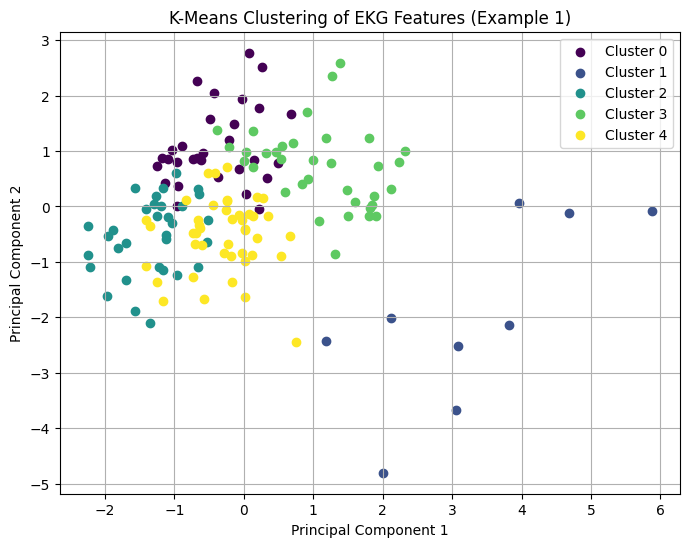


K-Means Cluster Labels (using Example 2 features):
 [1 1 0 1 1 3 0 4 0 2 1 0 1 1 1 0 4 4 1 0 1 1 1 1 0 1 1 4 1 0 1 1 0 1 0 1 1
 1 1 4 4 1 4 0 2 2 1 0 0 0 1 1 1 1 4 1 1 0 1 0 4 2 1 1 0 1 4 1 1 2 0 0 1 0
 1 1 4 1 0 2 4 1 2 4 1 4 0 1 1 4 1 1 0 1 0 1 4 1 0 1 4 1 2 1 1 1 1 0 0 4 1
 1 0 1 3 4 0 4 4 4 4 4 1 0 1 1 0 1 3 1 4 3 4 0 4 3 1 1 1 1 1 4 0 1 4 0 1 4
 4 0]


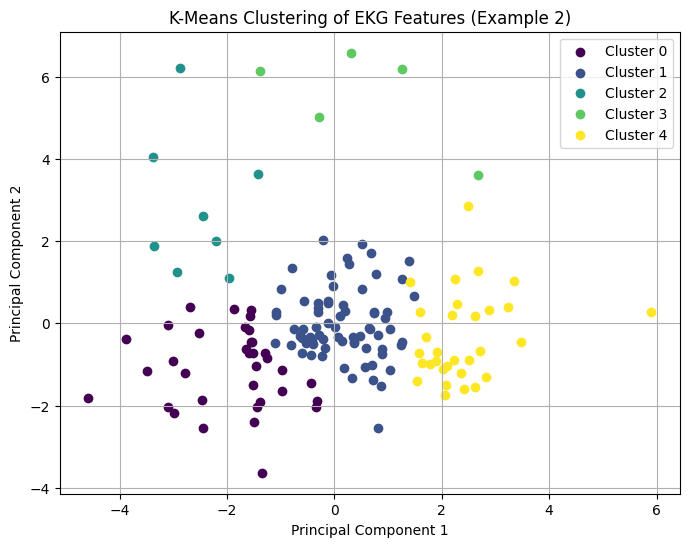

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

# Using features from Example 1
X = features_df_ex1.values
scaler = StandardScaler()
X_scaled_ex1 = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=random_state, n_init=10)
cluster_labels_kmeans = kmeans.fit_predict(X_scaled_ex1)

print("K-Means Cluster Labels:\n", cluster_labels_kmeans)

# Visualization
def visualize_clustering_2d(X, labels, title):
    """
    Performs 2D dimensionality reduction using PCA and visualizes the clustering.

    Args:
        X (np.array): The data to cluster.
        labels (np.array): Cluster labels for each data point.
        title (str): The title of the plot.
    """
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('viridis', len(unique_labels))
    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0]
        plt.scatter(X[indices, 0], X[indices, 1], label=f'Cluster {label}', color=cmap(i))
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize clustering results in 2D
visualize_clustering_2d(X_scaled_ex1, cluster_labels_kmeans, 'K-Means Clustering of EKG Features (Example 1)')

# Repeat for features from Example 2 (optional, for comparison)
X_ex2 = features_df_ex2.values
X_scaled_ex2 = scaler.fit_transform(X_ex2)

kmeans_ex2 = KMeans(n_clusters=5, random_state=random_state, n_init=10)
cluster_labels_kmeans_ex2 = kmeans_ex2.fit_predict(X_scaled_ex2)

print("\nK-Means Cluster Labels (using Example 2 features):\n", cluster_labels_kmeans_ex2)

# Visualization for Example 2
pca = PCA(n_components=2)
X_reduced_ex2 = pca.fit_transform(X_scaled_ex2)
visualize_clustering_2d(X_reduced_ex2, cluster_labels_kmeans_ex2, 'K-Means Clustering of EKG Features (Example 2)')

### 2.2 Bisecting K-Means Clustering

Bisecting k-means is a divisive hierarchical clustering algorithm. It starts with
all data points in one cluster and iteratively splits clusters into two sub-clusters
until the desired number of clusters is reached. The splitting process typically
involves using the standard k-means algorithm (with $k=2$) to find the best way
to divide a chosen cluster.

The algorithm generally proceeds as follows:

1.  Initialize by placing all data points into a single cluster.
2.  While the number of clusters is less than the desired number ($k$):
    a. Select a cluster to split (various strategies exist for this, such as choosing the largest cluster or the cluster with the highest Sum of Squared Errors (SSE)).
    b. Apply the standard k-means algorithm with $k=2$ to the selected cluster to find the best two sub-clusters.
    c. Replace the original cluster with these two new sub-clusters.

**Task:**

Implement the bisecting k-means algorithm. You can use the `KMeans` implementation from `sklearn.cluster` (with `n_clusters=2`) as the kernel for splitting the clusters.

Your implementation should:

1.  Take the scaled feature set (from either Example 1 or Example 2) and the desired number of clusters ($k=5$) as input.
2.  Initialize a list of clusters, starting with all data points in one cluster. You can represent a cluster by the indices of the data points belonging to it.
3.  Iteratively perform the splitting process until $k$ clusters are formed. For each split, you will need to:
    * Choose a cluster to split. A simple strategy is to choose the cluster with the largest number of data points.
    * Apply k-means ($k=2$) to the data points within the chosen cluster.
    * Update the list of clusters by replacing the split cluster with the two resulting sub-clusters.
4.  After the algorithm finishes, return the cluster assignments for each data point.

Finally, visualize the clustering results obtained from your bisecting k-means implementation (for $k=10$) by plotting the original time series, colored according to their assigned clusters. I've provided a function that can align the colors of the two clusterings based on the Euclidean distance of the cluster centroids. Compare these results with the clustering obtained from the standard k-means algorithm.


Bisecting K-Means Cluster Labels (using Example 2 features):
 [1 1 1 3 1 0 1 3 1 1 1 1 3 1 1 1 4 4 3 1 1 3 4 1 1 3 1 4 3 1 3 1 1 1 1 1 3
 3 3 4 2 3 2 1 0 0 3 1 1 1 1 1 1 1 2 3 1 1 3 1 2 0 3 1 1 1 4 1 3 0 1 1 3 1
 1 1 4 3 1 1 2 1 0 4 1 3 1 1 1 2 1 1 1 3 1 3 4 2 1 3 2 1 0 3 1 1 1 1 1 4 1
 1 1 1 2 2 1 2 4 2 4 4 1 1 1 1 1 3 0 1 4 2 3 1 4 0 1 3 3 3 1 3 1 1 2 1 2 2
 2 1]


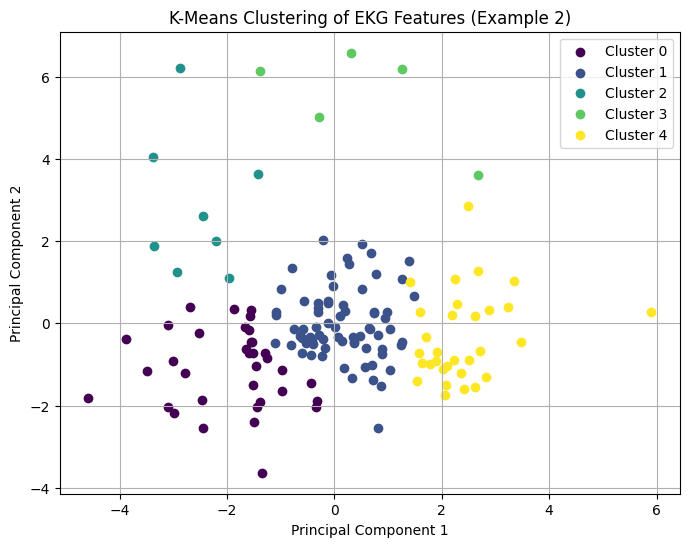

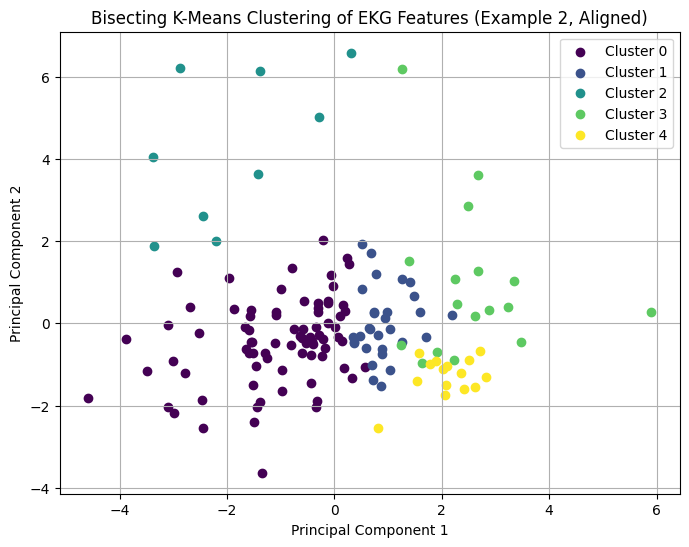

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def sse(data, labels, centers):
    """
    Computes the sum of squared errors (SSE) for the given data and cluster labels.

    Args:
        data (np.array): The data to compute SSE for.
        labels (np.array): Cluster labels for each data point.
        centers (np.array): Cluster centers.
    """
    return sum(np.min(pairwise_distances_argmin_min(data, centers)[1])**2 for i in range(len(data)))


def bisecting_kmeans(X, k, random_state=167, n_init=10):
    """
    Implements the bisecting k-means algorithm.

    Args:
        X (np.array): The data to cluster.
        k (int): The desired number of clusters.
        random_state (int): Random seed for reproducibility.
        n_init (int): Number of times k-means will be run with different centroid seeds.

    Returns:
        np.array: Cluster labels for each data point.
    """
    # Start with one cluster containing all data points
    clusters = [X]

    while len(clusters) < k:
        # Find cluster with max SSE or size or variance
        # Here, we use SSE as the criterion
        
        # extract the chosen cluster
        
        # Perform k-means on the chosen cluster with k=2 in order to split it into two subclusters
        
        # Extend the clusters list with the two new clusters
        cluster1 = ...
        cluster2 = ...
        clusters.extend([cluster1, cluster2])

    # Assign final labels to each sample in the original data
    final_labels = np.zeros(len(X), dtype=int)
    for i, cluster in enumerate(clusters):
        for row in cluster:
            ...
    return final_labels


# Apply bisecting k-means to the scaled features from Example 2
cluster_labels_bisecting_kmeans_ex2 = bisecting_kmeans(X_scaled_ex2, k=5, random_state=random_state)
print("\nBisecting K-Means Cluster Labels (using Example 2 features):\n", cluster_labels_bisecting_kmeans_ex2)

# Visualization of Bisecting K-Means results aligned with K-Means labels
def align_cluster_labels(X, labels1, labels2):
    """
    Aligns the cluster labels of two clusterings based on centroid similarity using 2D PCA representation of the data.

    Args:
        X (np.array): The data that were clustered, or a 2D representation of those samples.
        labels1 (np.array): Cluster labels for the first clustering.
        labels2 (np.array): Cluster labels for the second clustering.

    Returns:
        np.array: Re-labeled version of labels2, aligned with labels1.
    """
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
    # Compute centroids for both label sets
    centroids1 = np.array([X[labels1 == label].mean(axis=0) for label in np.unique(labels1)])
    centroids2 = np.array([X[labels2 == label].mean(axis=0) for label in np.unique(labels2)])
    
    # Create a cost matrix for the assignment problem.
    # The cost is the Euclidean distance between centroids.
    # This is a square matrix of size n_clusters1 x n_clusters2
    # where n_clusters1 and n_clusters2 are the number of unique labels 
    # in labels1 and labels2, respectively.
    n_clusters1 = len(np.unique(labels1))
    n_clusters2 = len(np.unique(labels2))

    if n_clusters1 != n_clusters2:
        raise ValueError("Number of clusters in both label sets must be the same for alignment.")

    cost_matrix = np.zeros((n_clusters1, n_clusters2))
    unique_labels1 = np.unique(labels1)
    unique_labels2 = np.unique(labels2)

    label_to_index1 = {label: i for i, label in enumerate(unique_labels1)}
    label_to_index2 = {label: i for i, label in enumerate(unique_labels2)}

    for label1 in unique_labels1:
        for label2 in unique_labels2:
            index1 = label_to_index1[label1]
            index2 = label_to_index2[label2]
            cost_matrix[index1, index2] = np.linalg.norm(centroids1[index1] - centroids2[index2])

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = {unique_labels2[col]: unique_labels1[row] for col, row in zip(col_ind, row_ind)}
    aligned_labels2 = np.array([label_mapping[label] for label in labels2])
    return aligned_labels2

# Align the cluster labels of bisecting k-means with k-means
aligned_labels = align_cluster_labels(X_reduced_ex2, cluster_labels_kmeans_ex2, cluster_labels_bisecting_kmeans_ex2)
visualize_clustering_2d(X_reduced_ex2, cluster_labels_kmeans_ex2, 'K-Means Clustering of EKG Features (Example 2)')
visualize_clustering_2d(X_reduced_ex2, aligned_labels, 'Bisecting K-Means Clustering of EKG Features (Example 2, Aligned)')

**Exercise:**

Experiment with different values for the `prominence` parameter in the `find_peaks` function in Example 1, the number of buckets in Example 2, or the way you choose the next cluster to bisect in the bisection k-means implementation. How does it affect the number of peaks detected and the result?